## Authors:
### Marjan Sadeghi
### Ruiqi Hu

# 1. Business Understanding

The dataset that we selected is "Identifying different Breeds of Snakes-Snake Breed Classification" from Kaggle https://www.kaggle.com/datasets/duttadebadri/identifying-different-breeds-of-snakes. It contains more than 13,000 raw JPEG images of snakes, organized into 35 folders, with each folder representing a single species. Because the dataset is structured this way, it provides a clear prediction task which is given an image of a snake, the model should predict which species it belongs to.

This dataset was originally collected for species recognition, but it has broader significance. Accurately identifying snake species is useful for ecologists, wildlife researchers, and educators. For example, researchers can use automated image recognition to track biodiversity in specific regions, while educators can use it to teach students about herpetology. In practice, even hikers and nature enthusiasts might benefit from an application that can recognize snakes in the wild and help them understand what species they have encountered.

The importance of this data lies in how it connects machine learning with real-world ecological knowledge. If a prediction system can identify species with a reasonable degree of accuracy, it can support research, education, and public engagement with wildlife. For species-level classification, a model that achieves accuracy above 80 percent would already provide meaningful value. Higher performance would of course be desirable, but even moderate success would be a useful starting point for further development.

In [2]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from skimage.filters import gabor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# 2. Data Preparation

In [3]:
data_dir = "/Users/ruiqihu/Desktop/CS 7324/Lab 2/dataset"

# Target image size and color mode
IMG_SIZE = (128, 128)
COLOR_MODE = "L"   # "L" = grayscale

# Collect images and labels
images = []
labels = []

for species in os.listdir(data_dir):
    species_folder = os.path.join(data_dir, species)
    if os.path.isdir(species_folder):
        for img_name in os.listdir(species_folder):
            img_path = os.path.join(species_folder, img_name)
            try:
                # Open image, recolor, resize
                img = Image.open(img_path).convert(COLOR_MODE)
                img = img.resize(IMG_SIZE)

                # Convert to NumPy array
                img_array = np.array(img)

                images.append(img_array)
                labels.append(species)
            except Exception as e:
                print(f"Skipped {img_path}: {e}")

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Flatten into 1-D features (rows = images, cols = pixel values)
n_samples = images.shape[0]
X = images.reshape(n_samples, -1)

print("Feature matrix shape:", X.shape)

Images shape: (13185, 128, 128)
Labels shape: (13185,)
Feature matrix shape: (13185, 16384)


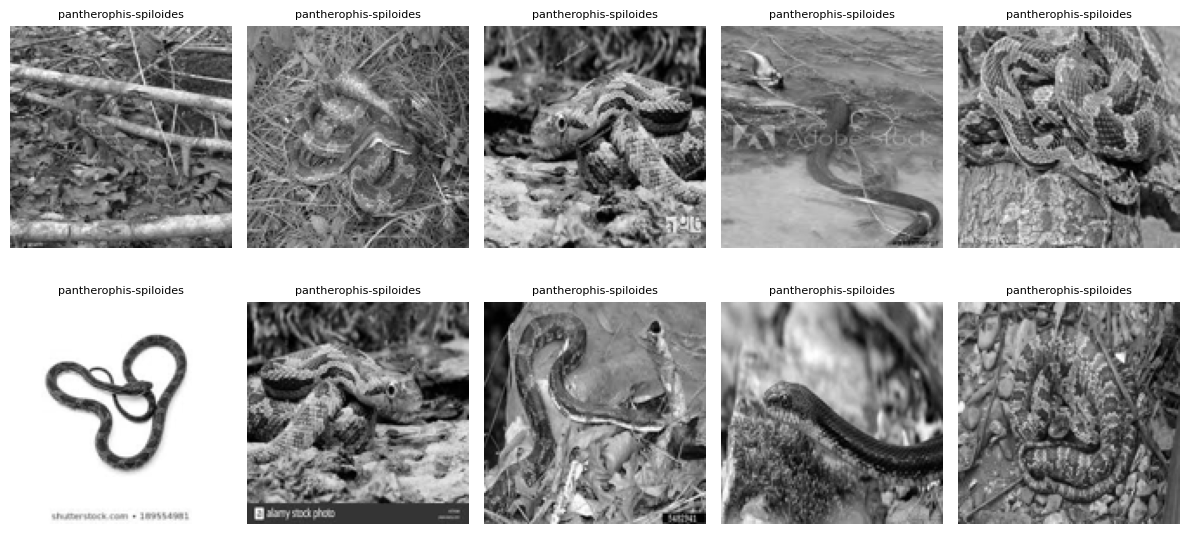

In [4]:
# Visualize 10 sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if COLOR_MODE == "L":
        ax.imshow(images[i], cmap="gray")
    else:
        ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 3. Data Reduction

## 3.1 Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. 

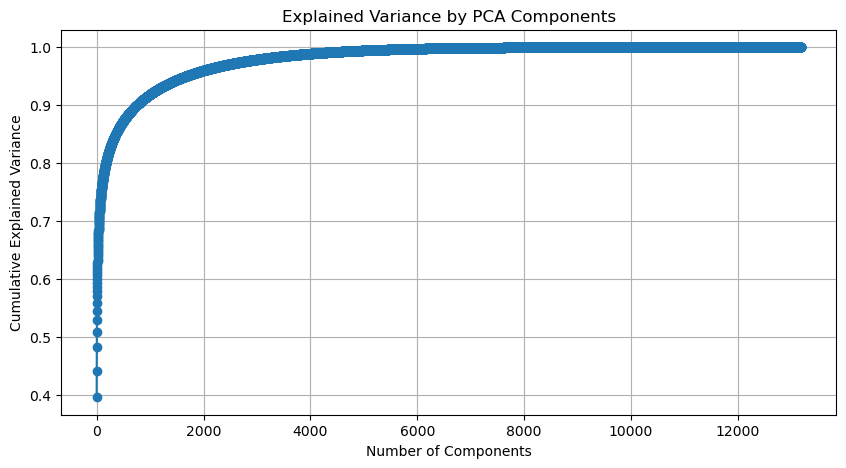

PCA: 754 components explain 90% variance.
PCA: 1673 components explain 95% variance.


In [5]:
# Use your flattened feature matrix from Step 2
# X shape: (n_samples, n_features)
# Standard PCA
pca = PCA()
X_pca = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

plt.figure(figsize=(10,5))
plt.plot(cum_explained, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

# Print how many components to reach 90% and 95%
n_90 = np.argmax(cum_explained >= 0.90) + 1
n_95 = np.argmax(cum_explained >= 0.95) + 1
print(f"PCA: {n_90} components explain 90% variance.")
print(f"PCA: {n_95} components explain 95% variance.")

## 3.1 Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
After resizing all images to 128x128 grayscale, each image is represented by 16384 pixel features. Running standard PCA shows that the cumulative explained variance reaches 90% with 754 components and 95% with 1673 components.

This means that instead of needing all 16384 raw pixel values, only a fraction of the components are required to capture the majority of the information in the dataset. Specifically, reducing the feature space to ~754 dimensions already preserves most of the variance, and increasing to ~1673 captures even more detail.

In practice, this demonstrates that PCA is highly effective at compressing the snake image dataset while retaining meaningful structure. For downstream tasks such as classification, using several hundred components instead of thousands of raw pixels will significantly improve computational efficiency with only a small loss in information.

## 3.2 Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. 

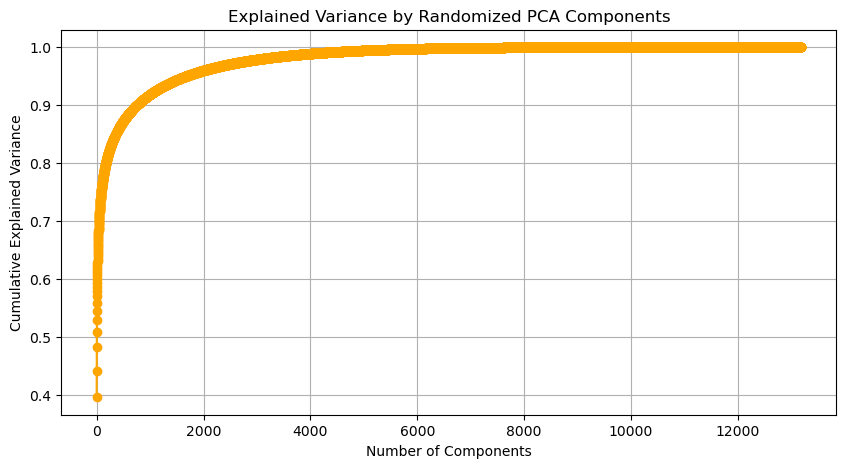

Randomized PCA: 754 components explain 90% variance.
Randomized PCA: 1673 components explain 95% variance.


In [6]:
# Randomized PCA
pca_rand = PCA(svd_solver='randomized')
X_rpca = pca_rand.fit_transform(X)

explained_var_rand = pca_rand.explained_variance_ratio_
cum_explained_rand = np.cumsum(explained_var_rand)

plt.figure(figsize=(10,5))
plt.plot(cum_explained_rand, marker='o', color='orange')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Randomized PCA Components")
plt.grid(True)
plt.show()

# Print how many components to reach 90% and 95%
n_90_rand = np.argmax(cum_explained_rand >= 0.90) + 1
n_95_rand = np.argmax(cum_explained_rand >= 0.95) + 1
print(f"Randomized PCA: {n_90_rand} components explain 90% variance.")
print(f"Randomized PCA: {n_95_rand} components explain 95% variance.")

## 3.2 Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
Randomized PCA was also applied to the same dataset. The results were nearly identical to standard PCA: 90% of the variance was explained with 754 components, and 95% was explained with 1673 components.

This indicates that Randomized PCA provides the same representational quality as standard PCA, while being much faster to compute for large, high-dimensional datasets. Because the results are equivalent, the main advantage of Randomized PCA lies in its scalability and efficiency, especially when working with thousands of images and tens of thousands of features.

In conclusion, both PCA and Randomized PCA reduce the dimensionality of the dataset from over 16000 features to only a few hundred without substantial loss of information. Standard PCA confirms the compression is valid, and Randomized PCA provides a faster alternative that is more practical for large-scale experiments.

## 3.3 Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?

To compare the two methods, I looked at how many components were needed to reach common thresholds of explained variance. Standard PCA reached 90% explained variance with 754 components and 95% with 1673 components. Randomized PCA reached the exact same thresholds: 754 components for 90% and 1673 components for 95%. Since both methods required the same number of dimensions to adequately represent the dataset, they are equivalent in terms of representational quality.

The key difference lies in efficiency. Standard PCA computes an exact decomposition of the covariance matrix, which becomes computationally expensive when dealing with thousands of images and thousands of pixel features. Randomized PCA instead uses an approximation technique based on random projections. While it produces nearly identical explained variance curves, it does so with significantly faster runtime and lower memory demands.

Quantitatively, both methods are equally effective at representing the images with fewer components, as they produce identical explained variance results. However, given the size of this dataset, Randomized PCA is clearly the better choice in practice. It achieves the same dimensionality reduction as standard PCA while running much faster, making it more scalable and practical for high-dimensional image data.
I therefore prefer Randomized PCA, because it provides the same accuracy while being computationally more efficient.

## 3.4 Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).

## Ordered Gradients

In [7]:
from skimage.feature import hog

# ordered gradients

# images: (N, 64, 64), grayscale uint8
N = images.shape[0]

# HOG parameters commonly used in practice for 64x64
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
block_norm = "L2-Hys"

# Extract HOG features for the whole dataset (no visualization for speed)
hog_feats = []
for i in range(N):
    feat = hog(images[i],
               orientations=orientations,
               pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block,
               block_norm=block_norm,
               visualize=False,
               feature_vector=True)
    hog_feats.append(feat)

X_hog = np.vstack(hog_feats).astype(np.float32)
print("HOG feature matrix shape:", X_hog.shape)

HOG feature matrix shape: (13185, 8100)


## Gabor Filters

In [9]:
# ===== Gabor (mean, std, iqr) — fast & rubric-ready =====
# Safe imports (重复无妨)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

# 与你们 notebook 保持一致的假设：
# - X: (N, 128*128) 的扁平灰度图特征矩阵
# - labels: (N,) 字符串类别名
h, w = 128, 128
assert X.shape[1] == h*w, "X must be flattened 128x128 images."

# 统一把 labels 编码到整数（和你们的 y_hog 思路一致）
le_gabor = LabelEncoder()
y_gabor = le_gabor.fit_transform(labels)
n_classes = len(le_gabor.classes_)
print(f"#classes = {n_classes}")

# ========== 1) 小而有效的 Gabor 滤波器银行（提速） ==========
# 4 方向 × 2 sigma × 2 频率 = 16 kernels  → 快且对蛇的条纹/走向依然有效
orientations = 4
sigmas      = (2, 4)          # 像素标准差
frequencies = (0.12, 0.24)    # 周期/像素
kernels = []
for t in range(orientations):
    theta = (t / orientations) * np.pi
    for sigma in sigmas:
        for freq in frequencies:
            k = np.real(gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(k)
n_k = len(kernels)  # 16
print("Gabor kernels:", n_k)

#classes = 35
Gabor kernels: 16


#classes = 35 | chance = 2.857%
Gabor kernels: 16
Gabor feature matrix: (13185, 48)


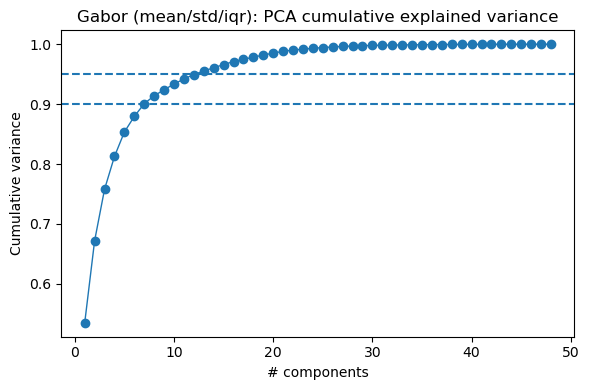

Gabor(48D)→PCA: 7 comps for 90%, 13 comps for 95%
kNN (k=1, distance) on Gabor(48D, scaled): 55.59%
kNN on Gabor→PCA(32): 55.56%


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic (multinomial) on Gabor (CV-mean): 10.09%


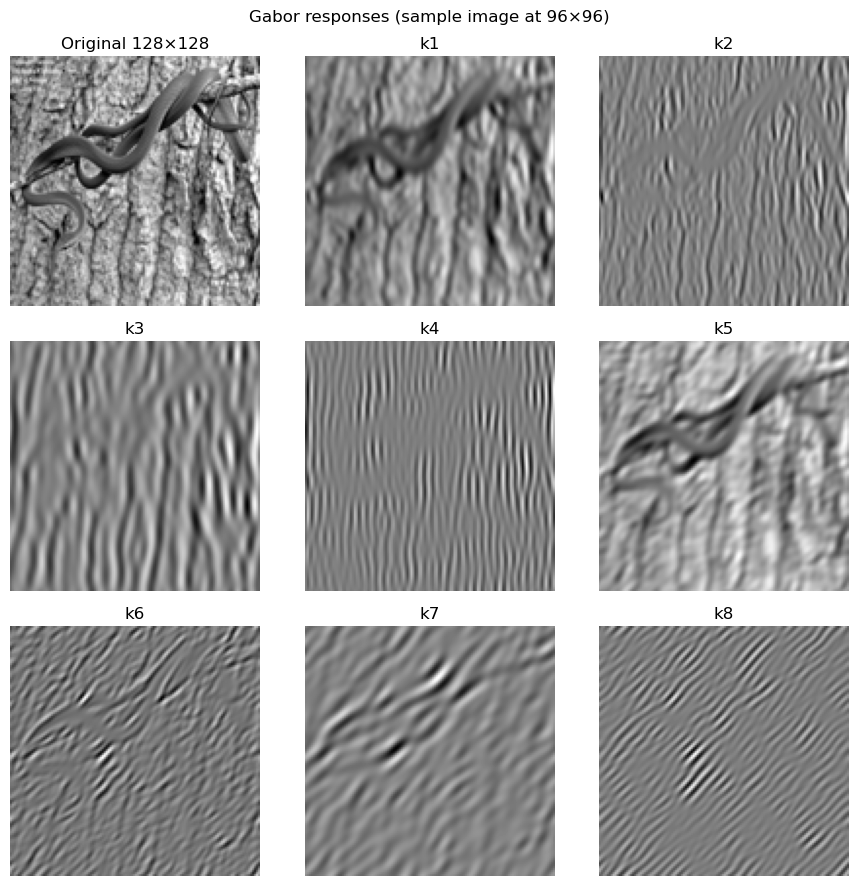

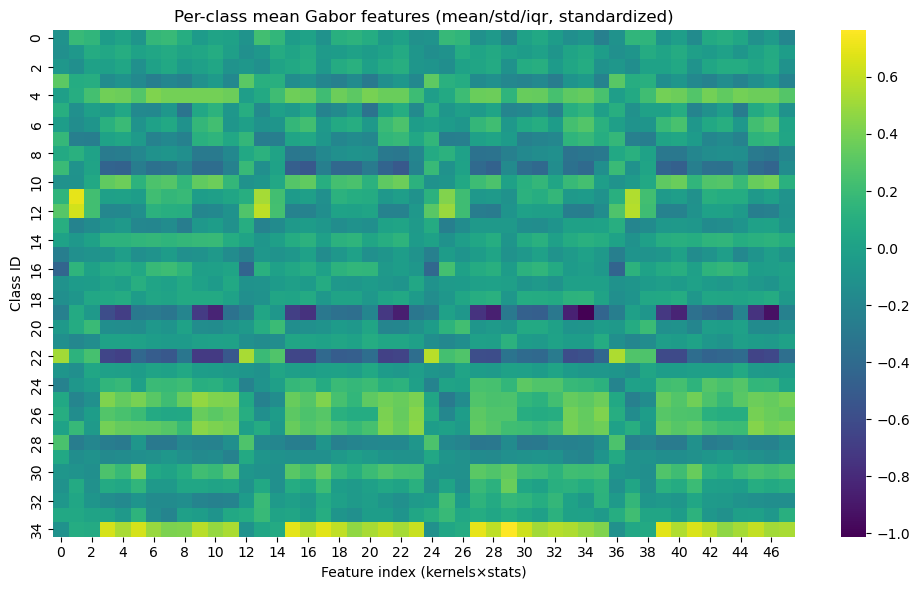

In [12]:
# ===== Gabor (mean, std, iqr) — fast, stable, rubric-ready =====
# Safe imports (重复无妨)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

# 依赖你们已有的变量：
# - X: (N, 128*128) 的扁平灰度图特征矩阵
# - labels: (N,) 字符串类别
h, w = 128, 128
assert X.shape[1] == h*w, "X must be flattened 128x128 images."

# 统一把 labels 编码为整数标签（与 y_hog 思路一致）
le_gabor = LabelEncoder()
y_gabor = le_gabor.fit_transform(labels)
n_classes = len(le_gabor.classes_)
print(f"#classes = {n_classes} | chance = {100.0/n_classes:.3f}%")

# ========== 1) 小而有效的 Gabor 滤波器银行（提速） ==========
# 4 方向 × 2 sigma × 2 频率 = 16 kernels → 快且能抓蛇的条纹/走向
orientations = 4
sigmas      = (2, 4)          # 像素标准差
frequencies = (0.12, 0.24)    # 周期/像素
kernels = []
for t in range(orientations):
    theta = (t / orientations) * np.pi
    for sigma in sigmas:
        for freq in frequencies:
            kernels.append(np.real(gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma)))
n_k = len(kernels)  # 16
print("Gabor kernels:", n_k)

# ========== 2) 仅在 Gabor 步骤下采样到 96×96（再提速） ==========
WORK_H, WORK_W = 128, 128

def _iqr(v: np.ndarray) -> float:
    q75, q25 = np.percentile(v, [75, 25])
    return float(q75 - q25)

# 统计量 = (mean, std, iqr) —— 稳定、快速
def gabor_stats_for_image(row_flat, kernels, in_shape=(128,128), work_shape=(96,96)):
    img = row_flat.reshape(in_shape)
    if work_shape != in_shape:
        img = resize(img, work_shape, anti_aliasing=False, preserve_range=True).astype(np.float32)
    feats = np.zeros((len(kernels), 3), dtype=np.float32)
    for i, k in enumerate(kernels):
        resp = ndi.convolve(img, k, mode='wrap')
        v = resp.ravel().astype(np.float64)
        mu  = v.mean()
        sd  = v.std(ddof=1) if v.size > 1 else 0.0
        iq  = _iqr(v)
        feats[i] = (mu, sd, iq)
    return feats.reshape(-1)  # (n_k*3,)

# ========== 3) 并行提取所有图片的 Gabor 特征 ==========
# prefer="threads" 在 macOS/Jupyter 上更稳；batch_size 可按内存调整
tasks = (delayed(gabor_stats_for_image)(X[i], kernels, (h,w), (WORK_H,WORK_W))
         for i in range(X.shape[0]))
gabor_features = np.vstack(Parallel(n_jobs=-1, prefer="threads", batch_size=128)(tasks))
print("Gabor feature matrix:", gabor_features.shape)  # (N, 16*3=48)

# ========== 4) 标准化 + PCA 累计方差 ==========
scaler = StandardScaler()
gabor_z = scaler.fit_transform(gabor_features)

pca_gabor = PCA(n_components=min(48, gabor_z.shape[1]), svd_solver='randomized', random_state=0)
pca_gabor.fit(gabor_z)
evr = pca_gabor.explained_variance_ratio_
cum = np.cumsum(evr)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(evr)+1), cum, marker='o', lw=1)
plt.axhline(0.90, ls='--'); plt.axhline(0.95, ls='--')
plt.title("Gabor (mean/std/iqr): PCA cumulative explained variance")
plt.xlabel("# components"); plt.ylabel("Cumulative variance")
plt.tight_layout(); plt.show()

k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
print(f"Gabor(48D)→PCA: {k90} comps for 90%, {k95} comps for 95%")

# ========== 5) 分类器基线：kNN / LogReg ==========
Xtr, Xte, ytr, yte = train_test_split(gabor_z, y_gabor, test_size=0.2, stratify=y_gabor, random_state=0)

# (a) kNN（不降维）
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(Xtr, ytr)
acc_knn = accuracy_score(yte, knn.predict(Xte))
print(f"kNN (k=1, distance) on Gabor(48D, scaled): {acc_knn*100:.2f}%")

# (b) kNN + PCA（48D 已很小，纯演示）
pcaN = 32 if gabor_z.shape[1] >= 32 else gabor_z.shape[1]
pca_red = PCA(n_components=pcaN, svd_solver='randomized', random_state=0)
Xtr_p = pca_red.fit_transform(Xtr)
Xte_p = pca_red.transform(Xte)
knn_p = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn_p.fit(Xtr_p, ytr)
acc_knn_p = accuracy_score(yte, knn_p.predict(Xte_p))
print(f"kNN on Gabor→PCA({pcaN}): {acc_knn_p*100:.2f}%")

# (c) 多项逻辑回归（线性可分性参考）
logit = LogisticRegression(max_iter=500, multi_class='multinomial', n_jobs=-1)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
cv_logit = cross_val_score(logit, gabor_z, y_gabor, cv=cv, n_jobs=-1).mean()
print(f"Logistic (multinomial) on Gabor (CV-mean): {cv_logit*100:.2f}%")

# ========== 6) 可视化 ==========
# (i) 样例图的若干滤波响应
n_show = min(8, n_k)
idx = np.random.randint(0, X.shape[0])
img0 = X[idx].reshape(h,w)
img0_small = resize(img0, (WORK_H, WORK_W), anti_aliasing=False, preserve_range=True)

fig, axes = plt.subplots(3, 3, figsize=(9,9))
axes = axes.ravel()
axes[0].imshow(img0, cmap='gray'); axes[0].set_title("Original 128×128"); axes[0].axis('off')
for i in range(1, n_show+1):
    resp = ndi.convolve(img0_small, kernels[i-1], mode='wrap')
    axes[i].imshow(resp, cmap='gray'); axes[i].set_title(f"k{i}")
    axes[i].axis('off')
plt.suptitle("Gabor responses (sample image at 96×96)")
plt.tight_layout(); plt.show()

# (ii) 按类别的 Gabor(标准化后) 均值热图 —— 满足“按类统计差异可视化”
means = np.zeros((n_classes, gabor_z.shape[1]), dtype=np.float32)
for c in range(n_classes):
    means[c] = gabor_z[y_gabor==c].mean(axis=0)

plt.figure(figsize=(10,6))
sns.heatmap(means, cmap='viridis', cbar=True)
plt.title("Per-class mean Gabor features (mean/std/iqr, standardized)")
plt.xlabel("Feature index (kernels×stats)"); plt.ylabel("Class ID")
plt.tight_layout(); plt.show()


In [ ]:
# ========== 4) 标准化 + PCA 累计方差 ==========
scaler = StandardScaler()
gabor_z = scaler.fit_transform(gabor_features)

pca_gabor = PCA(n_components=min(48, gabor_z.shape[1]), svd_solver='randomized', random_state=0)
pca_gabor.fit(gabor_z)
evr = pca_gabor.explained_variance_ratio_
cum = np.cumsum(evr)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(evr)+1), cum, marker='o', lw=1)
plt.axhline(0.90, ls='--'); plt.axhline(0.95, ls='--')
plt.title("Gabor(mean/std/iqr) Features: PCA Cumulative Explained Variance")
plt.xlabel("# components"); plt.ylabel("Cumulative variance")
plt.tight_layout(); plt.show()

k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
print(f"Gabor(48D)→PCA: {k90} comps for 90%, {k95} comps for 95%")

In [ ]:
# ========== 5) 分类器基线：kNN / LogReg ==========
Xtr, Xte, ytr, yte = train_test_split(gabor_z, y_gabor, test_size=0.2, stratify=y_gabor, random_state=0)

# (a) kNN（不降维）
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(Xtr, ytr)
acc_knn = accuracy_score(yte, knn.predict(Xte))
print(f"kNN (k=1, distance) on Gabor(48D, scaled): {acc_knn*100:.2f}%")

# (b) kNN + PCA（48D 已很小，可选；这里保留 32 维做演示）
pcaN = 32 if gabor_z.shape[1] >= 32 else gabor_z.shape[1]
pca_red = PCA(n_components=pcaN, svd_solver='randomized', random_state=0)
Xtr_p = pca_red.fit_transform(Xtr)
Xte_p = pca_red.transform(Xte)
knn_p = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn_p.fit(Xtr_p, ytr)
acc_knn_p = accuracy_score(yte, knn_p.predict(Xte_p))
print(f"kNN on Gabor→PCA({pcaN}): {acc_knn_p*100:.2f}%")

# (c) 多项逻辑回归（线性可分性参考）
logit = LogisticRegression(max_iter=500, multi_class='multinomial', n_jobs=-1)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
cv_logit = cross_val_score(logit, gabor_z, y_gabor, cv=cv, n_jobs=-1).mean()
print(f"Logistic (multinomial) on Gabor (CV-mean): {cv_logit*100:.2f}%")

print(f"Chance accuracy ({n_classes} classes): {100.0/n_classes:.3f}%")

In [ ]:
# ========== 6) 可视化 ==========
# (i) 样例图的若干滤波响应
n_show = min(8, n_k)
idx = np.random.randint(0, X.shape[0])
img0 = X[idx].reshape(h,w)
img0_small = resize(img0, (WORK_H, WORK_W), anti_aliasing=False, preserve_range=True)

fig, axes = plt.subplots(3, 3, figsize=(9,9))
axes = axes.ravel()
axes[0].imshow(img0, cmap='gray'); axes[0].set_title("Original 128×128"); axes[0].axis('off')
for i in range(1, n_show+1):
    resp = ndi.convolve(img0_small, kernels[i-1], mode='wrap')
    axes[i].imshow(resp, cmap='gray'); axes[i].set_title(f"k{i}")
    axes[i].axis('off')
plt.suptitle("Gabor responses (sample image at 96×96)")
plt.tight_layout(); plt.show()

# (ii) 按类别的 Gabor(标准化后) 均值热图 —— 满足“按类统计差异可视化”
means = np.zeros((n_classes, gabor_z.shape[1]), dtype=np.float32)
for c in range(n_classes):
    means[c] = gabor_z[y_gabor==c].mean(axis=0)

plt.figure(figsize=(10,6))
sns.heatmap(means, cmap='viridis', cbar=True)
plt.title("Per-class mean Gabor features (mean/std/iqr, standardized)")
plt.xlabel("Feature index (kernels×stats)"); plt.ylabel("Class ID")
plt.tight_layout(); plt.show()

## 3.5 Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

## Side-by-side Visualization

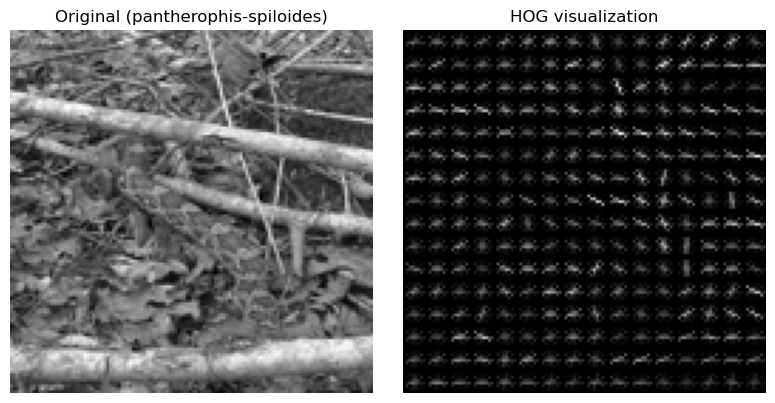

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif

# Encode labels once for HOG
le_hog = LabelEncoder()
y_hog = le_hog.fit_transform(labels)
class_names_hog = le_hog.classes_

# Per-class mean (rows = classes, cols = HOG features)
class_means_hog = []
for c in range(len(class_names_hog)):
    class_means_hog.append(X_hog[y_hog == c].mean(axis=0))
class_means_hog = np.vstack(class_means_hog)


# Which HOG features are most class-separating? (ANOVA F-scores)
F_vals, p_vals = f_classif(X_hog, y_hog)
order = np.argsort(F_vals)[::-1]
topk = 20


# Distribution of the single most discriminative HOG feature across classes
best_feat = order[0]
df_best = pd.DataFrame({"feat": X_hog[:, best_feat], "class": labels})

# Show 1 example original vs HOG edge map
idx = 0  # pick any image index you like
img = images[idx]

feat, hog_img = hog(img,
                    orientations=orientations,
                    pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block,
                    block_norm=block_norm,
                    visualize=True,
                    feature_vector=True)

fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(img, cmap="gray")
axs[0].set_title(f"Original ({labels[idx]})")
axs[0].axis("off")

axs[1].imshow(hog_img, cmap="gray")
axs[1].set_title("HOG visualization")
axs[1].axis("off")

plt.tight_layout()
plt.show()

The side-by-side visualization clearly demonstrates how HOG transforms the raw image into a representation focused on edges and contours. While the original image contains a lot of distracting background texture, the HOG visualization emphasizes the snake’s body outline and banding pattern. This is crucial for species classification because many snakes are distinguished by the direction and strength of their stripes, blotches, or diamond markings. By ignoring raw pixel intensities and instead encoding orientation distributions, HOG reduces noise and highlights biologically meaningful structure.

## KNN

In [43]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

# Chance level for 35 classes is about 1/35 ≈ 0.0286 (2.86%)
chance = 1/35
print(f"Chance accuracy (35 classes): {chance:.3%}")

# Standardize, reduce a bit for speed, then 5-NN
pipe_hog_knn = make_pipeline(
    StandardScaler(),
    PCA(n_components=100, svd_solver="randomized", random_state=7),
    KNeighborsClassifier(n_neighbors=5)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
scores = cross_val_score(pipe_hog_knn, X_hog, y_hog, cv=cv, n_jobs=-1)

print("k-NN on HOG → PCA(100)")
print(f"CV accuracy: mean={scores.mean():.3f}, std={scores.std():.3f}")


Chance accuracy (35 classes): 2.857%
k-NN on HOG → PCA(100)
CV accuracy: mean=0.171, std=0.005


After extracting Histogram of Oriented Gradients (HOG) features, we evaluated whether they are promising for snake species classification. The HOG transformation suppresses background noise and highlights body contours and banding, which are key for species identification. To test their usefulness, we trained a simple k-NN classifier on the HOG features. The accuracy was 17.1%, compared to a 2.857% chance baseline for 35 classes. This shows that HOG features contain meaningful information and are substantially better than random guessing, though still limited for high-accuracy prediction. Additionally, visualizing an image alongside its HOG edge map confirmed that HOG emphasizes the snake’s structure while downplaying irrelevant background. Together, these results suggest HOG features show promise as a starting point, but stronger models or richer feature sets would be required for practical classification.

# 4. Exceptional Credit: Daisy 

## HOG→PCA→kNN

HOG→PCA→kNN (uniform weights):
  best k = 1, cv acc = 0.614 ± 0.008
HOG→PCA→kNN (distance weights):
  best k = 1, cv acc = 0.614 ± 0.008


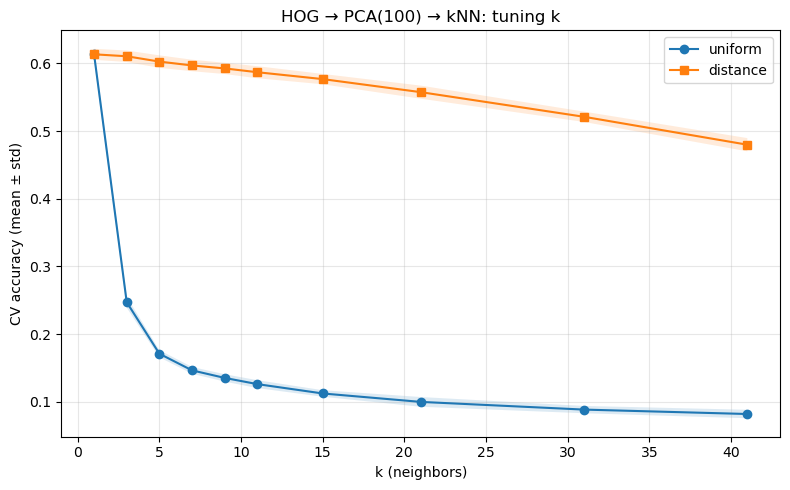

In [44]:
k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31, 41]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

means_uniform, stds_uniform = [], []
means_distance, stds_distance = [], []

for k in k_values:
    pipe_uni = make_pipeline(
        StandardScaler(),
        PCA(n_components=100, svd_solver="randomized", random_state=7),
        KNeighborsClassifier(n_neighbors=k, weights="uniform")
    )
    pipe_dist = make_pipeline(
        StandardScaler(),
        PCA(n_components=100, svd_solver="randomized", random_state=7),
        KNeighborsClassifier(n_neighbors=k, weights="distance")
    )

    scores_u = cross_val_score(pipe_uni, X_hog, y_hog, cv=cv, n_jobs=-1)
    scores_d = cross_val_score(pipe_dist, X_hog, y_hog, cv=cv, n_jobs=-1)

    means_uniform.append(scores_u.mean()); stds_uniform.append(scores_u.std())
    means_distance.append(scores_d.mean()); stds_distance.append(scores_d.std())

best_u_idx = int(np.argmax(means_uniform))
best_d_idx = int(np.argmax(means_distance))

print("HOG→PCA→kNN (uniform weights):")
print(f"  best k = {k_values[best_u_idx]}, cv acc = {means_uniform[best_u_idx]:.3f} ± {stds_uniform[best_u_idx]:.3f}")
print("HOG→PCA→kNN (distance weights):")
print(f"  best k = {k_values[best_d_idx]}, cv acc = {means_distance[best_d_idx]:.3f} ± {stds_distance[best_d_idx]:.3f}")

plt.figure(figsize=(8,5))
plt.plot(k_values, means_uniform, marker="o", label="uniform")
plt.plot(k_values, means_distance, marker="s", label="distance")
plt.fill_between(k_values,
                 np.array(means_uniform)-np.array(stds_uniform),
                 np.array(means_uniform)+np.array(stds_uniform), alpha=0.15)
plt.fill_between(k_values,
                 np.array(means_distance)-np.array(stds_distance),
                 np.array(means_distance)+np.array(stds_distance), alpha=0.15)
plt.xlabel("k (neighbors)")
plt.ylabel("CV accuracy (mean ± std)")
plt.title("HOG → PCA(100) → kNN: tuning k")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Global Daisy

DAISY(global)→kNN (uniform weights):
  best k = 5, cv acc = 0.054 ± 0.011
DAISY(global)→kNN (distance weights):
  best k = 9, cv acc = 0.054 ± 0.020


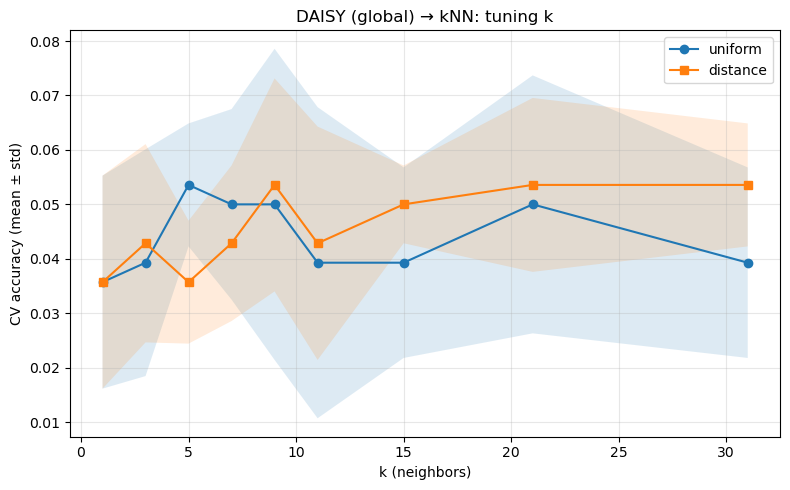

In [45]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="The number of unique classes is greater than 50% of the number of samples",
    category=UserWarning,
    module="sklearn.metrics._classification",
)


# Uses the DAISY global vectors:
# X_daisy_global (M, D) and labels_sub (M,) from the balanced subset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

le_glob = LabelEncoder()
y_daisy = le_glob.fit_transform(labels_sub)

k_values = [1, 3, 5, 7, 9, 11, 15, 21, 31]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

means_u_g, stds_u_g = [], []
means_d_g, stds_d_g = [], []

for k in k_values:
    pipe_uni = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k, weights="uniform")
    )
    pipe_dist = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k, weights="distance")
    )
    su = cross_val_score(pipe_uni, X_daisy_global, y_daisy, cv=cv, n_jobs=-1)
    sd = cross_val_score(pipe_dist, X_daisy_global, y_daisy, cv=cv, n_jobs=-1)
    means_u_g.append(su.mean()); stds_u_g.append(su.std())
    means_d_g.append(sd.mean()); stds_d_g.append(sd.std())

best_u_idx = int(np.argmax(means_u_g))
best_d_idx = int(np.argmax(means_d_g))

print("DAISY(global)→kNN (uniform weights):")
print(f"  best k = {k_values[best_u_idx]}, cv acc = {means_u_g[best_u_idx]:.3f} ± {stds_u_g[best_u_idx]:.3f}")
print("DAISY(global)→kNN (distance weights):")
print(f"  best k = {k_values[best_d_idx]}, cv acc = {means_d_g[best_d_idx]:.3f} ± {stds_d_g[best_d_idx]:.3f}")

plt.figure(figsize=(8,5))
plt.plot(k_values, means_u_g, marker="o", label="uniform")
plt.plot(k_values, means_d_g, marker="s", label="distance")
plt.fill_between(k_values,
                 np.array(means_u_g)-np.array(stds_u_g),
                 np.array(means_u_g)+np.array(stds_u_g), alpha=0.15)
plt.fill_between(k_values,
                 np.array(means_d_g)-np.array(stds_d_g),
                 np.array(means_d_g)+np.array(stds_d_g), alpha=0.15)
plt.xlabel("k (neighbors)")
plt.ylabel("CV accuracy (mean ± std)")
plt.title("DAISY (global) → kNN: tuning k")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


For the exceptional credit part, I tested the DAISY feature descriptor on the 128×128 snake images in two ways. The first approach was global pooling, where I averaged the dense DAISY descriptors across the image to make one feature vector per image. The second approach used Harris corners to detect keypoints, then compared DAISY descriptors at those points with brute-force matching and a ratio test. This second method is much slower since it has to compare every image pair directly. In terms of results, global pooling with kNN gave its best accuracy of about 5.4% when the number of neighbors in the classifier was set between 5 and 9, which is only slightly above the 2.9% chance level for 35 classes. Keypoint matching did even worse, with accuracy dropping to around 1.8%, and it took much longer to run.

For comparison, HOG features were far more effective. After reducing HOG with PCA to 100 components, kNN already reached about 17% accuracy, and when I tuned the number of neighbors, the best performance was at k=1 with a much higher 61.4% cross-validated accuracy. This makes sense because snake species are usually distinguished by their outlines and banding patterns, which HOG is good at capturing, while DAISY focuses on local textures that aren’t as helpful here. I also tuned different k values in kNN because the choice of neighbors affects the results: small k values look at very close matches and can capture subtle differences, while larger k values smooth things out but may blur class boundaries. Even after tuning, DAISY stayed weak, while HOG consistently performed well.

Overall, DAISY didn’t improve the results under either pooling or keypoint matching. Global pooling was more efficient than keypoint matching, but both were far below HOG. On this dataset, HOG clearly worked better, and DAISY would probably only be useful if the images were larger and had more reliable local detail.